In [1]:
import pandas as pd
from datetime import datetime
users = pd.read_csv('takehome_users.csv',parse_dates=['creation_time'])
logins = pd.read_csv('takehome_user_engagement.csv',parse_dates=['time_stamp'], index_col='time_stamp')

In [2]:
print(users.head())
print('-'*50)
print(logins.head())

   object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2    

In [112]:
print('Login Info \n')
print(logins.info())
print('-'*50)
print('User Info \n')
print(users.info())

Login Info 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 2 columns):
user_id    207917 non-null int64
visited    207917 non-null int64
dtypes: int64(2)
memory usage: 4.8 MB
None
--------------------------------------------------
User Info 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2),

In [93]:
print('Time period from {s} to {e}'.format(s=logins.index.min(), e=logins.index.max()))
print('Number of records in Login: ',logins.shape[0])
print('Number of users: ',users.object_id.nunique())

Time period from 2012-05-31 08:20:06 to 2014-06-06 14:58:50
Number of records in Login:  207917
Number of users:  12000


In [38]:
#Sum up all the logins for the day.
loginDay = logins.groupby('user_id')['visited'].resample('D').max().reset_index(level=0).rename(columns={'visited':'hasLogin'})

#if at least one login in day, then mark as 'hasLogin'
# loginDay['hasLogin'] = loginDay['visited']>0

#Count login days for 7 day period.
login7Days = loginDay.groupby('user_id')['hasLogin'].resample('7D').sum().reset_index().rename(columns={'hasLogin':'7DayLogins'})

#if login days are 3 more in 7 day period, mark user as adopted.
adoptedUsers = (login7Days.groupby('user_id')['7DayLogins'].max()>2).reset_index().rename(columns={'7DayLogins':'isAdopted'})

adoptedUsers.head(20)

,user_id,isAdopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False
5,6,False
6,7,False
7,10,True
8,11,False
9,13,False


In [131]:
#Feature extraction.

from datetime import datetime
import numpy as np

userEngagement = adoptedUsers.merge(users.drop(columns=['name','email']), left_on='user_id',right_on='object_id')
userEngagement['daysSinceCreation']=(pd.to_datetime(userEngagement.last_session_creation_time,unit='s')-userEngagement.creation_time).dt.days

# We suspect creation time might have influence but not the date.
# Hence extracting time from creation, as minutes from mid-night. And creation month.
userEngagement['creationTimeSinceMidnight'] = ((pd.to_datetime(userEngagement.creation_time)-pd.to_datetime(userEngagement.creation_time.dt.date))/pd.Timedelta('1 min')).astype(np.int64)
userEngagement['creationMonth'] = userEngagement['creation_time'].dt.month_name()

userEngagement = userEngagement.drop(columns=['object_id','last_session_creation_time','creation_time'])
userEngagement.head()

,user_id,isAdopted,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,daysSinceCreation,creationTimeSinceMidnight,creationMonth
0,1,False,GUEST_INVITE,1,0,11,10803.0,0,233,April
1,2,True,ORG_INVITE,0,0,1,316.0,136,225,November
2,3,False,ORG_INVITE,0,0,94,1525.0,0,1394,March
3,4,False,GUEST_INVITE,0,0,1,5151.0,1,489,May
4,5,False,GUEST_INVITE,0,0,193,5240.0,5,614,January


In [116]:
userEngagement.columns=['user_id', 'isAdopted', 'creationSource', 'mailingList','marketingDrip', 'orgID', 'invitedBy','daysSinceCreation','creationMonth','creationTimeSinceMidnight']
userEngagement.head()

,user_id,isAdopted,creationSource,mailingList,marketingDrip,orgID,invitedBy,daysSinceCreation,creationMonth,creationTimeSinceMidnight
0,1,False,GUEST_INVITE,1,0,11,10803.0,0,April,233
1,2,True,ORG_INVITE,0,0,1,316.0,136,November,225
2,3,False,ORG_INVITE,0,0,94,1525.0,0,March,1394
3,4,False,GUEST_INVITE,0,0,1,5151.0,1,May,489
4,5,False,GUEST_INVITE,0,0,193,5240.0,5,January,614


In [117]:
# Adding information about the invited user.
userInvitedUser = userEngagement.merge(userEngagement, left_on='invitedBy',right_on='user_id', suffixes=('','_invited'),validate='m:1')
userInvitedUser = userInvitedUser.drop(columns=['user_id_invited','invitedBy_invited'])
userInvitedUser.head(10)

,user_id,isAdopted,creationSource,mailingList,marketingDrip,orgID,invitedBy,daysSinceCreation,creationMonth,creationTimeSinceMidnight,isAdopted_invited,creationSource_invited,mailingList_invited,marketingDrip_invited,orgID_invited,daysSinceCreation_invited,creationMonth_invited,creationTimeSinceMidnight_invited
0,1,False,GUEST_INVITE,1,0,11,10803.0,0,April,233,False,SIGNUP,0,0,11,0,August,392
1,2,True,ORG_INVITE,0,0,1,316.0,136,November,225,False,ORG_INVITE,1,0,1,0,August,178
2,5085,False,ORG_INVITE,0,0,1,316.0,3,March,1032,False,ORG_INVITE,1,0,1,0,August,178
3,3,False,ORG_INVITE,0,0,94,1525.0,0,March,1394,True,GUEST_INVITE,1,1,94,216,June,1390
4,2352,False,GUEST_INVITE,0,0,94,1525.0,0,October,239,True,GUEST_INVITE,1,1,94,216,June,1390
5,3069,False,GUEST_INVITE,1,0,94,1525.0,84,January,28,True,GUEST_INVITE,1,1,94,216,June,1390
6,7294,False,ORG_INVITE,0,0,94,1525.0,2,November,1153,True,GUEST_INVITE,1,1,94,216,June,1390
7,7363,False,ORG_INVITE,1,1,94,1525.0,0,April,1400,True,GUEST_INVITE,1,1,94,216,June,1390
8,9755,False,ORG_INVITE,0,0,94,1525.0,3,April,560,True,GUEST_INVITE,1,1,94,216,June,1390
9,10071,False,ORG_INVITE,0,0,94,1525.0,2,September,1232,True,GUEST_INVITE,1,1,94,216,June,1390


In [118]:
# OrgID itself may not mean much 
# but if the user and user who invites the user belong to the same org that could be important.
userInvitedUser['sameOrg'] = userInvitedUser['orgID']==userInvitedUser['orgID_invited']
userInvitedUser.head()

,user_id,isAdopted,creationSource,mailingList,marketingDrip,orgID,invitedBy,daysSinceCreation,creationMonth,creationTimeSinceMidnight,isAdopted_invited,creationSource_invited,mailingList_invited,marketingDrip_invited,orgID_invited,daysSinceCreation_invited,creationMonth_invited,creationTimeSinceMidnight_invited,sameOrg
0,1,False,GUEST_INVITE,1,0,11,10803.0,0,April,233,False,SIGNUP,0,0,11,0,August,392,True
1,2,True,ORG_INVITE,0,0,1,316.0,136,November,225,False,ORG_INVITE,1,0,1,0,August,178,True
2,5085,False,ORG_INVITE,0,0,1,316.0,3,March,1032,False,ORG_INVITE,1,0,1,0,August,178,True
3,3,False,ORG_INVITE,0,0,94,1525.0,0,March,1394,True,GUEST_INVITE,1,1,94,216,June,1390,True
4,2352,False,GUEST_INVITE,0,0,94,1525.0,0,October,239,True,GUEST_INVITE,1,1,94,216,June,1390,True


In [119]:
#dropping user_id, invitedBy, orgID and orgID_invited, 
# as these are IDs would be too gradunlar information to feed into the model.
slimedDF = userInvitedUser.drop(columns=['user_id', 'invitedBy', 'orgID', 'orgID_invited'])
slimedDF.head()

,isAdopted,creationSource,mailingList,marketingDrip,daysSinceCreation,creationMonth,creationTimeSinceMidnight,isAdopted_invited,creationSource_invited,mailingList_invited,marketingDrip_invited,daysSinceCreation_invited,creationMonth_invited,creationTimeSinceMidnight_invited,sameOrg
0,False,GUEST_INVITE,1,0,0,April,233,False,SIGNUP,0,0,0,August,392,True
1,True,ORG_INVITE,0,0,136,November,225,False,ORG_INVITE,1,0,0,August,178,True
2,False,ORG_INVITE,0,0,3,March,1032,False,ORG_INVITE,1,0,0,August,178,True
3,False,ORG_INVITE,0,0,0,March,1394,True,GUEST_INVITE,1,1,216,June,1390,True
4,False,GUEST_INVITE,0,0,0,October,239,True,GUEST_INVITE,1,1,216,June,1390,True


In [122]:
dfEncoded=pd.get_dummies(slimedDF).astype(float)
dfEncoded.head()

,isAdopted,mailingList,marketingDrip,daysSinceCreation,creationTimeSinceMidnight,isAdopted_invited,mailingList_invited,marketingDrip_invited,daysSinceCreation_invited,creationTimeSinceMidnight_invited,...,creationMonth_invited_December,creationMonth_invited_February,creationMonth_invited_January,creationMonth_invited_July,creationMonth_invited_June,creationMonth_invited_March,creationMonth_invited_May,creationMonth_invited_November,creationMonth_invited_October,creationMonth_invited_September
0,0.0,1.0,0.0,0.0,233.0,0.0,0.0,0.0,0.0,392.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,136.0,225.0,0.0,1.0,0.0,0.0,178.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,3.0,1032.0,0.0,1.0,0.0,0.0,178.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1394.0,1.0,1.0,1.0,216.0,1390.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,239.0,1.0,1.0,1.0,216.0,1390.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [80]:
import sklearn.metrics as metrics 
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_auc(X_test,y_test, cv):
    print('Test Score: ',cv.score(X_test,y_test))

    probs = cv.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('ROC')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def trainModel(pipeline, dfEncoded, parameters, X_train, X_test, y_train, y_test):
    cv = GridSearchCV(pipeline, cv=5, param_grid=parameters, iid=True)
    cv.fit(X_train, y_train)
    print('Best Estimator:', cv.best_estimator_)
    plot_roc_auc(X_test,y_test, cv)
    return cv

def plotFeatureImportance(model,X):
    forest = model.best_estimator_.steps[1][1]
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. %s %d (%f)" % (f + 1,X.columns[f], indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

#Scales all numeric features 0 to 1.
scaler = MinMaxScaler()

# Classifier with 500 trees
r_clf = RandomForestClassifier(random_state=42, n_estimators=700)


# Setting up pipelines in required order
steps1 = [('Scaler',scaler),('Classifier',r_clf)]
pipeline1 = Pipeline(steps1)

# Parameters for tunning while GridSearch and n-folds.
parameters1 = {'Classifier__max_depth':[10, 15, 30], 'Classifier__max_features':['auto','sqrt','log2']}

Lets test model performance with and without pepping into the future. That is knowing and not knowing how much user has used the product. So we will experiment, if having daysSinceCreation helps and if so how much. In that way can be sure if are users that stay for long time are really engaged.

### Random Forest

**** daysSinceCreation included ****


Best Estimator: Pipeline(memory=None,
     steps=[('Scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
Test Score:  0.9663394109396914


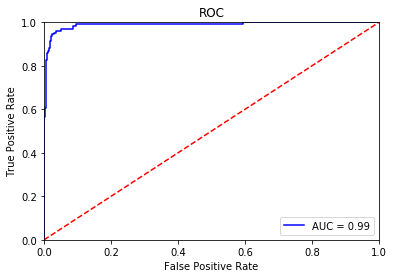

Feature ranking:
1. mailingList 2 (0.697855)
2. marketingDrip 3 (0.047640)
3. daysSinceCreation 8 (0.045647)
4. creationTimeSinceMidnight 7 (0.035586)
5. isAdopted_invited 4 (0.008647)
6. mailingList_invited 0 (0.008001)
7. marketingDrip_invited 5 (0.007418)
8. daysSinceCreation_invited 20 (0.007055)
9. creationTimeSinceMidnight_invited 11 (0.006865)
10. sameOrg 24 (0.006852)
11. creationSource_GUEST_INVITE 25 (0.006794)
12. creationSource_ORG_INVITE 10 (0.006632)
13. creationMonth_April 1 (0.006532)
14. creationMonth_August 6 (0.006018)
15. creationMonth_December 35 (0.005851)
16. creationMonth_February 34 (0.005629)
17. creationMonth_January 28 (0.005446)
18. creationMonth_July 30 (0.005202)
19. creationMonth_June 13 (0.005150)
20. creationMonth_March 27 (0.005143)
21. creationMonth_May 18 (0.004820)
22. creationMonth_November 17 (0.004718)
23. creationMonth_October 38 (0.004384)
24. creationMonth_September 39 (0.004345)
25. creationSource_invited_GUEST_INVITE 19 (0.004251)
26. creat

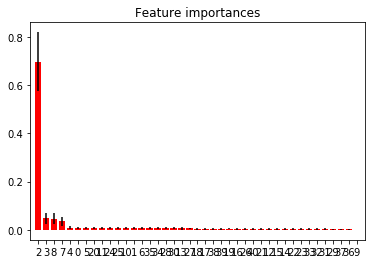

**** daysSinceCreation not included ****


Best Estimator: Pipeline(memory=None,
     steps=[('Scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Classifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
Test Score:  0.82328190743338


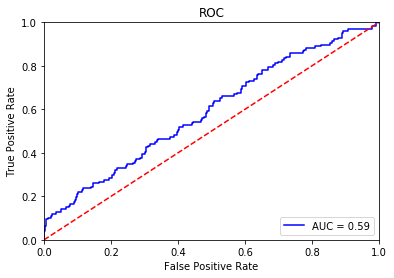

Feature ranking:
1. mailingList 2 (0.169037)
2. marketingDrip 7 (0.158814)
3. creationTimeSinceMidnight 6 (0.119249)
4. isAdopted_invited 0 (0.026871)
5. mailingList_invited 4 (0.025814)
6. marketingDrip_invited 1 (0.022845)
7. daysSinceCreation_invited 24 (0.022500)
8. creationTimeSinceMidnight_invited 3 (0.022083)
9. sameOrg 5 (0.021886)
10. creationSource_GUEST_INVITE 9 (0.021441)
11. creationSource_ORG_INVITE 23 (0.021382)
12. creationMonth_April 10 (0.020235)
13. creationMonth_August 33 (0.019612)
14. creationMonth_December 34 (0.019553)
15. creationMonth_February 19 (0.018470)
16. creationMonth_January 12 (0.017688)
17. creationMonth_July 26 (0.017677)
18. creationMonth_June 29 (0.016661)
19. creationMonth_March 27 (0.016270)
20. creationMonth_May 16 (0.016076)
21. creationMonth_November 17 (0.015906)
22. creationMonth_October 38 (0.014423)
23. creationMonth_September 21 (0.014018)
24. creationSource_invited_GUEST_INVITE 37 (0.013782)
25. creationSource_invited_ORG_INVITE 15 (0.0

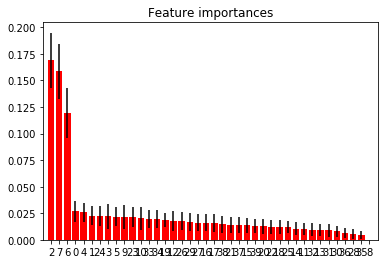

In [129]:
featuresToBeDropped = [['isAdopted'],['isAdopted','daysSinceCreation']]

for dropfeatures in featuresToBeDropped:
    # Spearating target and features
    X = dfEncoded.drop(columns=dropfeatures)
    y = dfEncoded['isAdopted']

    #Spliting training and testing into 80/20 ratio.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('**** daysSinceCreation included ****') if len(dropfeatures)==1 else print('**** daysSinceCreation not included ****')
    print('\n')
    trained_rclf = trainModel(pipeline1, dfEncoded, parameters1, X_train, X_test, y_train, y_test)
    plotFeatureImportance(trained_rclf,X)
    print('='*100)

### SVM

**** daysSinceCreation included ****


Best Estimator: Pipeline(memory=None,
     steps=[('Scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Classifier', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
Test Score:  0.9396914446002805


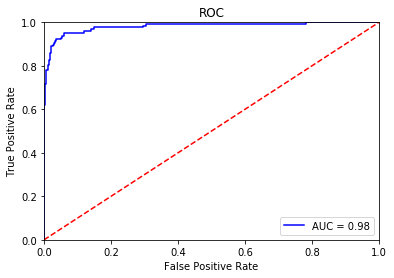

**** daysSinceCreation not included ****


Best Estimator: Pipeline(memory=None,
     steps=[('Scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('Classifier', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
Test Score:  0.8218793828892006


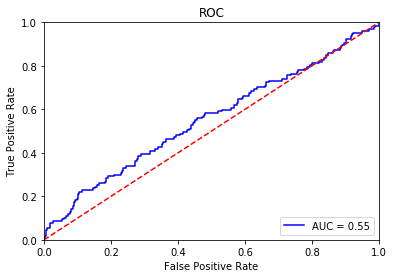

In [130]:
from sklearn import svm
svm_clf = svm.SVC(gamma='scale', probability=True, random_state=42)
steps2 = [('Scaler',scaler),('Classifier',svm_clf)]
pipeline2 = Pipeline(steps2)

# Parameters for tunning while GridSearch and n-folds.
parameters2 = {}

for dropfeatures in featuresToBeDropped:
    # Spearating target and features
    X = dfEncoded.drop(columns=dropfeatures)
    y = dfEncoded['isAdopted']

    #Spliting training and testing into 80/20 ratio.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print('**** daysSinceCreation included ****') if len(dropfeatures)==1 else print('**** daysSinceCreation not included ****')
    print('\n')
    trained_svmclf = trainModel(pipeline2, dfEncoded, parameters2, X_train, X_test, y_train, y_test)
    print('='*100)